In [ ]:
import pandas as pd 

import keras
from keras import Input
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Model

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import datetime
import numpy as np

from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

In [28]:
room1_indoor = pd.read_csv('ROBOD/combined_Room1.csv')
room2_indoor = pd.read_csv('ROBOD/combined_Room2.csv')
room3_indoor = pd.read_csv('ROBOD/combined_Room3.csv')
room4_indoor = pd.read_csv('ROBOD/combined_Room4.csv')
room5_indoor = pd.read_csv('ROBOD/combined_Room5.csv')

In [29]:
room1_indoor.dropna(how='any', inplace=True)
room1_indoor.reset_index(drop=True)
room1_indoor.isna().sum().sum()

0

In [8]:
room2_indoor.dropna(how='any', inplace=True)
room2_indoor.reset_index(drop=True)
room2_indoor.isna().sum().sum()

0

In [9]:
room3_indoor.dropna(how='any', inplace=True)
room3_indoor.reset_index(drop=True)
room3_indoor.isna().sum().sum()

0

In [10]:
room4_indoor.dropna(how='any', inplace=True)
room4_indoor.reset_index(drop=True)
room4_indoor.isna().sum().sum()

0

In [11]:
room5_indoor.dropna(how='any', inplace=True)
room5_indoor.reset_index(drop=True)
room5_indoor.isna().sum().sum()

0

In [ ]:
# start with the rooms as the most full dataset 
room1_indoor['timestamp']= pd.to_datetime(room1_indoor.timestamp)
room1_indoor['timestamp'].dt.tz_localize(None)

In [32]:
room1_indoor.isna().sum().sum()

0

In [ ]:
# Extracting the hour of day
room1_indoor["hour"] = [x.hour for x in room1_indoor["timestamp"]]
# Creating the cyclical daily feature 
room1_indoor["day_cos"] = [np.cos(x * (2 * np.pi / 24)) for x in room1_indoor["hour"]]
room1_indoor["day_sin"] = [np.sin(x * (2 * np.pi / 24)) for x in room1_indoor["hour"]]

room1_indoor["timestamp"] = [x.timestamp() for x in room1_indoor["timestamp"]]
# Seconds in day 
s = 24 * 60 * 60
# Seconds in year 
year = (365.25) * s
room1_indoor["month_cos"] = [np.cos((x) * (2 * np.pi / year)) for x in room1_indoor["timestamp"]]
room1_indoor["month_sin"] = [np.sin((x) * (2 * np.pi / year)) for x in room1_indoor["timestamp"]]

In [34]:
def create_X_Y(ts: np.array, lag=1, n_ahead=1, target_index=0) -> tuple:
    """
    A method to create X and Y matrix from a time series array for the training of 
    deep learning models 
    """
    # Extracting the number of features that are passed from the array 
    n_features = ts.shape[1]
    
    # Creating placeholder lists
    X, Y = [], []

    if len(ts) - lag <= 0:
        X.append(ts)
    else:
        for i in range(len(ts) - lag - n_ahead):
            Y.append(ts[(i + lag):(i + lag + n_ahead), target_index])
            X.append(ts[i:(i + lag)])
            
    X, Y = np.array(X), np.array(Y)

    # Reshaping the X array to an RNN input shape 
    X = np.reshape(X, (X.shape[0], lag, n_features))

    return X, Y

In [98]:
room1_indoor.columns.to_list()

['timestamp',
 'voc',
 'sound_pressure_level',
 'indoor_relative_humidity',
 'air_temperature',
 'illuminance',
 'pm2.5',
 'indoor_co2',
 'wifi_connected_devices',
 'ceiling_fan_energy',
 'lighting_energy',
 'plug_load_energy',
 'chilled_water_energy',
 'fcu_fan_energy',
 'temp_setpoint',
 'fcu_fan_speed',
 'supply_air_pressure',
 'supply_air_temperature',
 'baromatic_pressure',
 'dry_bulb_temp',
 'global_horizontal_solar_radiation',
 'wind_direction',
 'wind_speed',
 'outdoor_co2',
 'rainfall_raw',
 'outdoor_relative_humidity',
 'occupant_presence',
 'occupant_count',
 'hour',
 'day_cos',
 'day_sin',
 'month_cos',
 'month_sin']

In [ ]:
room1_indoor= room1_indoor.append(room2_indoor)

In [50]:
room1_indoor.dropna(how='any', inplace=True)
room1_indoor.reset_index(drop=True)
room1_indoor.isna().sum().sum()

0

# Temperature

In [208]:
# Number of lags (hours back) to use for models
lag = 30
# Steps ahead to forecast 
n_ahead = 5
# Share of obs in testing 
test_share = 0.1
# Epochs for training
epochs = 20
# Batch size 
batch_size = 8
# Learning rate
lr = 0.001
# Number of neurons in LSTM layer
n_layer = 12
# The features use in the modeling 
features_final = ['air_temperature', 'day_cos', 'day_sin', 'month_sin', 'month_cos', 'sound_pressure_level', 'wind_speed',
                 'fcu_fan_speed','supply_air_pressure','supply_air_temperature', 'occupant_count']

In [209]:
# Subseting only the needed columns 
ts =  room1_indoor[features_final]
nrows = ts.shape[0]
# Spliting into train and test sets
train = ts[0:int(nrows * (1 - test_share))]
test = ts[int(nrows * (1 - test_share)):]
# Scaling the data 
train_mean = train.mean()
train_std = train.std()
train = (train - train_mean) / train_std
test = (test - train_mean) / train_std
# Creating the final scaled frame 
ts_s = pd.concat([train, test])
# Creating the X and Y for training
X, Y = create_X_Y(ts_s.values, lag=lag, n_ahead=n_ahead)
n_ft = X.shape[2]

In [210]:
print ('X shape', X.shape)
print ('Y shape', Y.shape)

X shape (8293, 30, 11)
Y shape (8293, 5)


In [211]:
# Spliting into train and test sets 
Xtrain, Ytrain = X[0:int(X.shape[0] * (1 - test_share))], Y[0:int(X.shape[0] * (1 - test_share))]
Xval, Yval = X[int(X.shape[0] * (1 - test_share)):], Y[int(X.shape[0] * (1 - test_share)):]

In [212]:
from keras import backend as K
import gc

def clean_up(model):
    K.clear_session()
    del model
    gc.collect()
clean_up(model)

In [213]:
input_dim = (Xtrain.shape[1], Xtrain.shape[2])

model = Sequential()
model.add(LSTM(30, input_shape=input_dim, return_sequences=True)) # return the full sequence instead of just the last output. so the output shape of this layer is (None, 7, 64)
model.add(LSTM(15, activation='tanh', return_sequences=False))
#model.add(Dropout(0.2))
model.add(Dense(50))
model.add(Dense(Ytrain.shape[1]))

model.compile(optimizer='adam', loss='mse')
#model.summary()

history = model.fit(Xtrain, Ytrain, epochs=5, batch_size=32, validation_split=.2, verbose=1)

Train on 5970 samples, validate on 1493 samples
Epoch 1/5
5970/5970 [==============================] - 12s 2ms/step - loss: 0.1727 - val_loss: 0.8676
Epoch 2/5
5970/5970 [==============================] - 11s 2ms/step - loss: 0.0551 - val_loss: 0.5991
Epoch 3/5
5970/5970 [==============================] - 12s 2ms/step - loss: 0.0469 - val_loss: 0.5741
Epoch 4/5
5970/5970 [==============================] - 12s 2ms/step - loss: 0.0430 - val_loss: 0.5855
Epoch 5/5
5970/5970 [==============================] - 12s 2ms/step - loss: 0.0402 - val_loss: 0.5089


In [ ]:
# Quick plot of the loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Model Loss')

plt.xticks(range(5)) # set the ticks to be integral numbers instead of default float
plt.xlabel(xlabel='epoch')
plt.ylabel(ylabel='loss')
plt.legend()

In [215]:
# Comparing the forecasts with the actual values
yhat = [x[0] for x in model.predict(Xval)]
y = [y[0] for y in Yval]
# Creating the frame to store both predictions
days = room1_indoor['timestamp'].values[-len(y):]
frame = pd.concat([
 pd.DataFrame({'day': days, 'temp': y, 'type': 'original'}),
 pd.DataFrame({'day': days, 'temp': yhat, 'type': 'forecast'})
])
# Creating the unscaled values column
frame['temp_absolute'] = [(x * train_std['air_temperature']) + train_mean['air_temperature'] for x in frame['temp']]
# Pivoting
pivoted = frame.pivot_table(index='day', columns='type')
pivoted.columns = ['_'.join(x).strip() for x in pivoted.columns.values]
pivoted['res'] = pivoted['temp_absolute_original'] - pivoted['temp_absolute_forecast']
pivoted['res_abs'] = [abs(x) for x in pivoted['res']]

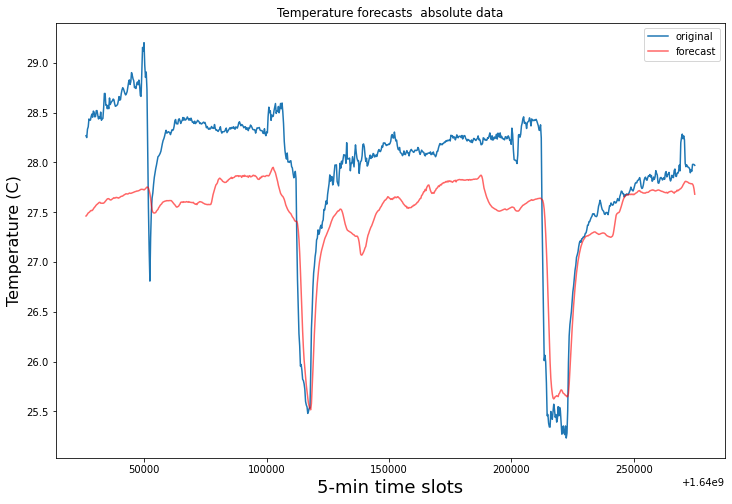

R-squared = 0.31124307770163606
Mean Squared Error (MSE) = 0.36810921555000287
Root Mean Squared Error (RMSE) = 0.6067200470975085
Mean Absolute Error (MAE) = 0.5311988599299458
Normalized Root Mean Squared Error (NRMSE) = 0.021714733979450937
Normalized deviation (ND) = 0.019011802871436324


(0.31124307770163606,
 0.36810921555000287,
 0.6067200470975085,
 0.5311988599299458,
 0.021714733979450937,
 0.019011802871436324)

In [217]:

plt.figure(figsize=(12, 8))
plt.plot(pivoted.index, pivoted.temp_absolute_original, label='original')
plt.plot(pivoted.index, pivoted.temp_absolute_forecast, color='red', label='forecast', alpha=0.6)
plt.title('Temperature forecasts  absolute data')
plt.legend()
plt.xlabel('5-min time slots', fontsize=18)
plt.ylabel('Temperature (C)', fontsize=16)
plt.show()
full_model_evaluation(pivoted['temp_absolute_original'],pivoted['temp_absolute_forecast'])

# Humidity

In [180]:
# Number of lags (hours back) to use for models
lag = 30
# Steps ahead to forecast 
n_ahead = 5
# Share of obs in testing 
test_share = 0.1
# Epochs for training
epochs = 20
# Batch size 
batch_size = 8
# Learning rate
lr = 0.001
# Number of neurons in LSTM layer
n_layer = 12
# The features use in the modeling 
features_final = ['indoor_relative_humidity', 'day_cos', 'day_sin', 'month_sin', 'month_cos', 'sound_pressure_level', 'wind_speed',
                 'fcu_fan_speed','supply_air_pressure','supply_air_temperature', 'occupant_count']

In [181]:
# Subseting only the needed columns 
ts =  room1_indoor[features_final]
nrows = ts.shape[0]
# Spliting into train and test sets
train = ts[0:int(nrows * (1 - test_share))]
test = ts[int(nrows * (1 - test_share)):]
# Scaling the data 
train_mean = train.mean()
train_std = train.std()
train = (train - train_mean) / train_std
test = (test - train_mean) / train_std
# Creating the final scaled frame 
ts_s = pd.concat([train, test])
# Creating the X and Y for training
X, Y = create_X_Y(ts_s.values, lag=lag, n_ahead=n_ahead)
n_ft = X.shape[2]

In [182]:
# Spliting into train and test sets 
Xtrain, Ytrain = X[0:int(X.shape[0] * (1 - test_share))], Y[0:int(X.shape[0] * (1 - test_share))]
Xval, Yval = X[int(X.shape[0] * (1 - test_share)):], Y[int(X.shape[0] * (1 - test_share)):]

In [183]:
Xval.shape

(830, 30, 11)

In [185]:
input_dim = (Xtrain.shape[1], Xtrain.shape[2])

model2 = Sequential()
model2.add(LSTM(30, input_shape=input_dim, return_sequences=True)) # return the full sequence instead of just the last output. so the output shape of this layer is (None, 7, 64)
model2.add(LSTM(15, activation='tanh', return_sequences=False))
model2.add(Dense(Ytrain.shape[1]))

model2.compile(optimizer='adam', loss='mse')

history = model2.fit(Xtrain, Ytrain, epochs=5, batch_size=32, validation_split=.2, verbose=1)

Train on 5970 samples, validate on 1493 samples
Epoch 1/5
5970/5970 [==============================] - 12s 2ms/step - loss: 0.2796 - val_loss: 0.6940
Epoch 2/5
5970/5970 [==============================] - 12s 2ms/step - loss: 0.1280 - val_loss: 0.5885
Epoch 3/5
5970/5970 [==============================] - 12s 2ms/step - loss: 0.1129 - val_loss: 0.5251
Epoch 4/5
5970/5970 [==============================] - 12s 2ms/step - loss: 0.1062 - val_loss: 0.4788
Epoch 5/5
5970/5970 [==============================] - 12s 2ms/step - loss: 0.0979 - val_loss: 0.4459


In [ ]:
# Quick plot of the loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Model Loss')

plt.xticks(range(5)) # set the ticks to be integral numbers instead of default float
plt.xlabel(xlabel='epoch')
plt.ylabel(ylabel='loss')
plt.legend()

In [205]:
# Comparing the forecasts with the actual values
yhat = [x[0] for x in model2.predict(Xval)]
y = [y[0] for y in Yval]
# Creating the frame to store both predictions
days = room1_indoor['timestamp'].values[-len(y):]
frame2 = pd.concat([
 pd.DataFrame({'day': days, 'hum': y, 'type': 'original'}),
 pd.DataFrame({'day': days, 'hum': yhat, 'type': 'forecast'})
])
# Creating the unscaled values column
frame2['hum_absolute'] = [(x * train_std['indoor_relative_humidity']) + train_mean['indoor_relative_humidity'] 
                         for x in frame2['hum']]
# Pivoting
pivoted2 = frame.pivot_table(index='day', columns='type')
pivoted2.columns = ['_'.join(x).strip() for x in pivoted2.columns.values]
pivoted2['res'] = pivoted2['hum_absolute_original'] - pivoted2['hum_absolute_forecast']
pivoted2['res_abs'] = [abs(x) for x in pivoted['res']]

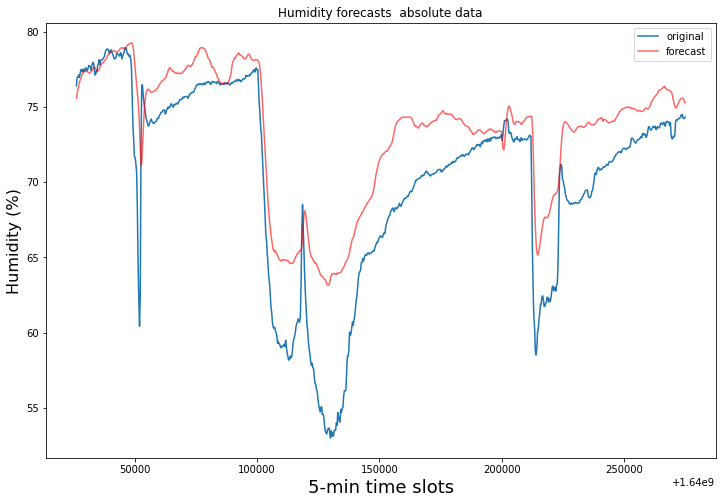

R-squared = 0.6116535741670953
Mean Squared Error (MSE) = 16.22267383663694
Root Mean Squared Error (RMSE) = 4.027738054620352
Mean Absolute Error (MAE) = 3.187000649002591
Normalized Root Mean Squared Error (NRMSE) = 0.05733068280823381
Normalized deviation (ND) = 0.04536365593785494


(0.6116535741670953,
 16.22267383663694,
 4.027738054620352,
 3.187000649002591,
 0.05733068280823381,
 0.04536365593785494)

In [218]:

plt.figure(figsize=(12, 8))
plt.plot(pivoted2.index, pivoted2.hum_absolute_original, label='original')
plt.plot(pivoted2.index, pivoted2.hum_absolute_forecast, color='red', label='forecast', alpha=0.6)
plt.title('Humidity forecasts  absolute data')
plt.legend()
plt.xlabel('5-min time slots', fontsize=18)
plt.ylabel('Humidity (%)', fontsize=16)
plt.show()
plt.show()
full_model_evaluation(pivoted2['hum_absolute_original'],pivoted2['hum_absolute_forecast'])

# PM2.5 

In [161]:
# Number of lags (hours back) to use for models
lag = 30
# Steps ahead to forecast 
n_ahead = 5
# Share of obs in testing 
test_share = 0.1
# Epochs for training
epochs = 20
# Batch size 
batch_size = 8
# Learning rate
lr = 0.001
# Number of neurons in LSTM layer
n_layer = 12
# The features use in the modeling 
features_final = ['pm2.5','indoor_relative_humidity','air_temperature',  
                  'day_cos', 'day_sin', 'month_sin', 'month_cos',
                  'sound_pressure_level', 'wind_speed',
                 'fcu_fan_speed','supply_air_pressure','supply_air_temperature', 'occupant_count']

In [162]:
# Subseting only the needed columns 
ts =  room1_indoor[features_final]
nrows = ts.shape[0]
# Spliting into train and test sets
train = ts[0:int(nrows * (1 - test_share))]
test = ts[int(nrows * (1 - test_share)):]
# Scaling the data 
train_mean = train.mean()
train_std = train.std()
train = (train - train_mean) / train_std
test = (test - train_mean) / train_std
# Creating the final scaled frame 
ts_s = pd.concat([train, test])
# Creating the X and Y for training
X, Y = create_X_Y(ts_s.values, lag=lag, n_ahead=n_ahead)
n_ft = X.shape[2]

In [163]:
# Spliting into train and test sets 
Xtrain, Ytrain = X[0:int(X.shape[0] * (1 - test_share))], Y[0:int(X.shape[0] * (1 - test_share))]
Xval, Yval = X[int(X.shape[0] * (1 - test_share)):], Y[int(X.shape[0] * (1 - test_share)):]

In [164]:
Xval.shape

(830, 30, 13)

In [166]:
input_dim = (Xtrain.shape[1], Xtrain.shape[2])

model3 = Sequential()
model3.add(LSTM(30, input_shape=input_dim, return_sequences=True)) # return the full sequence instead of just the last output. so the output shape of this layer is (None, 7, 64)
model3.add(LSTM(15, activation='tanh', return_sequences=False))
#model.add(Dropout(0.2))
#model2.add(Dense(50))
model3.add(Dense(Ytrain.shape[1]))

model3.compile(optimizer='adam', loss='mse')
#model.summary()

history = model3.fit(Xtrain, Ytrain, epochs=5, batch_size=32, validation_split=.2, verbose=1)

Train on 5970 samples, validate on 1493 samples
Epoch 1/10
5970/5970 [==============================] - 12s 2ms/step - loss: 0.1210 - val_loss: 1.6546
Epoch 2/10
5970/5970 [==============================] - 11s 2ms/step - loss: 0.0296 - val_loss: 1.3628
Epoch 3/10
5970/5970 [==============================] - 12s 2ms/step - loss: 0.0211 - val_loss: 1.2622
Epoch 4/10
5970/5970 [==============================] - 12s 2ms/step - loss: 0.0182 - val_loss: 1.2152
Epoch 5/10
5970/5970 [==============================] - 12s 2ms/step - loss: 0.0157 - val_loss: 1.2286
Epoch 6/10
5970/5970 [==============================] - 12s 2ms/step - loss: 0.0146 - val_loss: 1.1326
Epoch 7/10
5970/5970 [==============================] - 11s 2ms/step - loss: 0.0133 - val_loss: 1.1388
Epoch 8/10
5970/5970 [==============================] - 12s 2ms/step - loss: 0.0117 - val_loss: 1.1230
Epoch 9/10
5970/5970 [==============================] - 12s 2ms/step - loss: 0.0111 - val_loss: 1.1021
Epoch 10/10
5970/5970 [==

In [ ]:
# Quick plot of the loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Model Loss')

plt.xticks(range(5)) # set the ticks to be integral numbers instead of default float
plt.xlabel(xlabel='epoch')
plt.ylabel(ylabel='loss')
plt.legend()

In [169]:
# Comparing the forecasts with the actual values
yhat = [x[0] for x in model3.predict(Xval)]
y = [y[0] for y in Yval]
# Creating the frame to store both predictions
days = room1_indoor['timestamp'].values[-len(y):]
frame3 = pd.concat([
 pd.DataFrame({'day': days, 'dust': y, 'type': 'original'}),
 pd.DataFrame({'day': days, 'dust': yhat, 'type': 'forecast'})
])
# Creating the unscaled values column
frame3['pm2.5_absolute'] = [(x * train_std['pm2.5']) + train_mean['pm2.5'] for x in frame3['dust']]
# Pivoting
pivoted3 = frame3.pivot_table(index='day', columns='type')
pivoted3.columns = ['_'.join(x).strip() for x in pivoted3.columns.values]
pivoted3['res'] = pivoted3['pm2.5_absolute_original'] - pivoted3['pm2.5_absolute_forecast']
pivoted3['res_abs'] = [abs(x) for x in pivoted['res']]

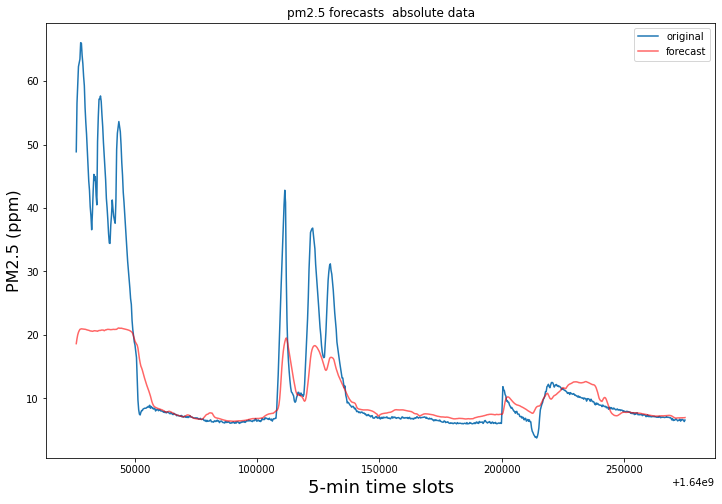

R-squared = 0.4668922616481136
Mean Squared Error (MSE) = 81.45167430257504
Root Mean Squared Error (RMSE) = 9.025058132919424
Mean Absolute Error (MAE) = 3.9216597531182416
Normalized Root Mean Squared Error (NRMSE) = 0.7126408139769312
Normalized deviation (ND) = 0.30966391101779134


(0.4668922616481136,
 81.45167430257504,
 9.025058132919424,
 3.9216597531182416,
 0.7126408139769312,
 0.30966391101779134)

In [219]:

plt.figure(figsize=(12, 8))
plt.plot(pivoted3.index, pivoted3['pm2.5_absolute_original'], label='original')
plt.plot(pivoted3.index, pivoted3['pm2.5_absolute_forecast'], color='red', label='forecast', alpha=0.6)
plt.title('pm2.5 forecasts  absolute data')
plt.legend()
plt.xlabel('5-min time slots', fontsize=18)
plt.ylabel('PM2.5 (ppm)', fontsize=16)
plt.show()
plt.show()
full_model_evaluation(pivoted3['pm2.5_absolute_original'],pivoted3['pm2.5_absolute_forecast'])

# CO2 

In [149]:
# Number of lags (hours back) to use for models
lag = 30
# Steps ahead to forecast 
n_ahead = 5
# Share of obs in testing 
test_share = 0.1
# Epochs for training
epochs = 20
# Batch size 
batch_size = 8
# Learning rate
lr = 0.001
# Number of neurons in LSTM layer
n_layer = 12
# The features use in the modeling 
features_final = ['indoor_co2','indoor_relative_humidity','air_temperature',  
                  'day_cos', 'day_sin', 'month_sin', 'month_cos',
                  'sound_pressure_level', 'wind_speed',
                 'fcu_fan_speed','supply_air_pressure','supply_air_temperature', 'occupant_count']

In [150]:
# Subseting only the needed columns 
ts =  room1_indoor[features_final]
nrows = ts.shape[0]
# Spliting into train and test sets
train = ts[0:int(nrows * (1 - test_share))]
test = ts[int(nrows * (1 - test_share)):]
# Scaling the data 
train_mean = train.mean()
train_std = train.std()
train = (train - train_mean) / train_std
test = (test - train_mean) / train_std
# Creating the final scaled frame 
ts_s = pd.concat([train, test])
# Creating the X and Y for training
X, Y = create_X_Y(ts_s.values, lag=lag, n_ahead=n_ahead)
n_ft = X.shape[2]

In [151]:
# Spliting into train and test sets 
Xtrain, Ytrain = X[0:int(X.shape[0] * (1 - test_share))], Y[0:int(X.shape[0] * (1 - test_share))]
Xval, Yval = X[int(X.shape[0] * (1 - test_share)):], Y[int(X.shape[0] * (1 - test_share)):]

In [152]:
Xval.shape

(830, 30, 13)

In [155]:
input_dim = (Xtrain.shape[1], Xtrain.shape[2])

model4 = Sequential()
model4.add(LSTM(30, input_shape=input_dim, return_sequences=True)) # return the full sequence instead of just the last output. so the output shape of this layer is (None, 7, 64)
model4.add(LSTM(15, activation='tanh', return_sequences=False))

model4.add(Dense(Ytrain.shape[1]))

model4.compile(optimizer='adam', loss='mse')


history = model4.fit(Xtrain, Ytrain, epochs=5, batch_size=32, validation_split=.2, verbose=1)

Train on 5970 samples, validate on 1493 samples
Epoch 1/5
5970/5970 [==============================] - 12s 2ms/step - loss: 0.3943 - val_loss: 0.4322
Epoch 2/5
5970/5970 [==============================] - 12s 2ms/step - loss: 0.1053 - val_loss: 0.3566
Epoch 3/5
5970/5970 [==============================] - 12s 2ms/step - loss: 0.0682 - val_loss: 0.3705
Epoch 4/5
5970/5970 [==============================] - 12s 2ms/step - loss: 0.0545 - val_loss: 0.4189
Epoch 5/5
5970/5970 [==============================] - 12s 2ms/step - loss: 0.0447 - val_loss: 0.4406


In [ ]:
# Quick plot of the loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Model Loss')

plt.xticks(range(5)) # set the ticks to be integral numbers instead of default float
plt.xlabel(xlabel='epoch')
plt.ylabel(ylabel='loss')
plt.legend()

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from math import sqrt

def full_model_evaluation(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    nrmse = sqrt(mean_squared_error(y_true, y_pred)) / np.mean(y_true)
    nd = np.sum(np.abs(y_true-y_pred)) / np.sum(np.abs(y_true))
    print("R-squared = "+str(r2))
    print("Mean Squared Error (MSE) = "+str(mse))
    print("Root Mean Squared Error (RMSE) = "+str(rmse))
    print("Mean Absolute Error (MAE) = "+str(mae))
    print("Normalized Root Mean Squared Error (NRMSE) = "+str(nrmse))
    print("Normalized deviation (ND) = "+str(nd))
    return r2, mse, rmse, mae, nrmse, nd

In [159]:
# Comparing the forecasts with the actual values
yhat = [x[0] for x in model4.predict(Xval)]
y = [y[0] for y in Yval]
# Creating the frame to store both predictions
days = room1_indoor['timestamp'].values[-len(y):]
frame4 = pd.concat([
 pd.DataFrame({'day': days, 'CO2': y, 'type': 'original'}),
 pd.DataFrame({'day': days, 'CO2': yhat, 'type': 'forecast'})
])
# Creating the unscaled values column
frame4['indoor_co2_absolute'] = [(x * train_std['indoor_co2']) + train_mean['indoor_co2'] for x in frame4['CO2']]
# Pivoting
pivoted4 = frame4.pivot_table(index='day', columns='type')
pivoted4.columns = ['_'.join(x).strip() for x in pivoted4.columns.values]
pivoted4['res'] = pivoted4['indoor_co2_absolute_original'] - pivoted4['indoor_co2_absolute_forecast']
pivoted4['res_abs'] = [abs(x) for x in pivoted4['res']]

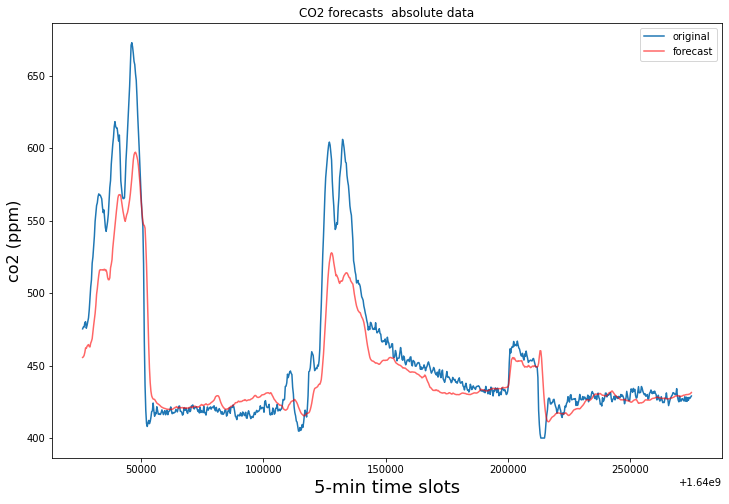

R-squared = 0.785126423131452
Mean Squared Error (MSE) = 665.5620600787246
Root Mean Squared Error (RMSE) = 25.79848949219168
Mean Absolute Error (MAE) = 14.948102900884908
Normalized Root Mean Squared Error (NRMSE) = 0.056642483447420094
Normalized deviation (ND) = 0.03281966067780721


(0.785126423131452,
 665.5620600787246,
 25.79848949219168,
 14.948102900884908,
 0.056642483447420094,
 0.03281966067780721)

In [220]:
plt.figure(figsize=(12, 8))
plt.plot(pivoted4.index, pivoted4['indoor_co2_absolute_original'], label='original')
plt.plot(pivoted4.index, pivoted4['indoor_co2_absolute_forecast'], color='red', label='forecast', alpha=0.6)
plt.title('CO2 forecasts  absolute data')
plt.legend()
plt.xlabel('5-min time slots', fontsize=18)
plt.ylabel('co2 (ppm)', fontsize=16)
plt.show()
plt.show()
full_model_evaluation(pivoted4['indoor_co2_absolute_original'],pivoted4['indoor_co2_absolute_forecast'])